In [1]:
%load_ext autoreload
%autoreload 2

## AGN DCR Metric
This notebook build upon the prototype shown in [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb) but with a focus on the integration with MAF and provide the ability to use more realistic astrometric errors simulated by OpSim. 

### 0. Software Setup

In [1]:
your_username = 'ywx649999311'

In [2]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

## 1. The Metric
### 1.1 Load in simulated DCR data (used to define metric)

In [4]:
# load in data and merge into one df
dcr_data_dir = 'DCR_data/'
dfZ = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshifts.dat'))
dfQSO = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshiftfit.dat'), \
                                index_col=0, header=None, sep=' ').T.dropna().reset_index(drop=True)
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
0,0.40,0.3790,0.1143,0.1995,0.2466,0.0012,0.0258
1,0.45,0.2507,0.0644,0.2651,0.2032,0.0053,0.0506
2,0.50,0.2023,0.0410,0.2679,0.1762,0.0002,0.0589
3,0.55,0.3056,0.0252,0.2351,0.1314,-0.0140,0.0357
4,0.60,0.3419,0.0727,0.1867,0.1570,-0.0083,0.0143


### 1.2 Define the metric

In [5]:
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils.astrometryUtils import m52snr, astrom_precision

class AGN_dcr_proto(BaseMetric):
    """AGN DCR"""
    
    def __init__(self, band, src_mag=22, seeingCol='seeingFwhmGeom', m5Col='fiveSigmaDepth',
                 PACol='paraAngle', filterCol='filter', atm_err=0.01, **kwargs):
        
        self.band = band # required
        self.src_mag = src_mag
        self.m5Col = m5Col
        self.PACol = PACol
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.atm_err = 0.01
        self.metricName = f'DCR_{src_mag}_{self.band}'
        
        cols=['airmass', self.filterCol, self.m5Col, self.PACol, self.seeingCol]
        super(AGN_dcr_proto, self).__init__(col=cols, metricName=self.metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # get the data only corresponding the the desired filter
        data_filt = dataSlice[np.where(dataSlice[self.filterCol] == self.band)]
        
        # compute snr and astrometric precision for given data slice
        snr = m52snr(self.src_mag, data_filt[self.m5Col])
        pos_var = np.power(astrom_precision(data_filt[self.seeingCol], snr), 2) \
                  + self.atm_err**2
        pos_err = np.sqrt(pos_var)
        
        # compute tan(Z), note that we might change sin(PA)
        zenith = np.arccos(1/data_filt['airmass'])
        x_coord = np.tan(zenith)*np.sin(data_filt[self.PACol])
        
        ## peter's version
        # function is of form, y=ax. a=y/x. da = dy/x.
        # Only strictly true if we know the unshifted position. But this should be a reasonable approx.
        slope_uncerts = pos_err/x_coord
        total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2))

        # So, this will be the uncertainty in the RA or Dec offset at x= +/- 1.
        result = total_slope_uncert

#         ## version from Bevington page 109 from least-square
#         Delta = np.sum(1/pos_var)*np.sum(x_coord**2/pos_var) - np.power(np.sum(x_coord/pos_var), 2)
#         result = np.sqrt(np.sum(x_coord**2/pos_var)/Delta)
        
        return result

In [ ]:
class DcrPrecisionMetric(BaseMetric):
    """Determine how precise a DCR correction could be made
    Parameters
    ----------
    atm_err : float
        Minimum error in photometry centroids introduced by the atmosphere (arcseconds). Default 0.01.
    """

    def __init__(self, metricName='DCRprecision', seeingCol='seeingFwhmGeom',
                 m5Col='fiveSigmaDepth', HACol='HA', PACol='paraAngle',
                 filterCol='filter', atm_err=0.01, SedTemplate='flat',
                 rmag=20., **kwargs):

        self.m5Col = m5Col
        self.filterCol = filterCol
        self.PACol = PACol
        self.seeingCol = seeingCol
        self.mags = {}
        self.filters = ['u', 'g', 'r', 'i', 'z', 'y']
        if SedTemplate == 'flat':
            for f in self.filters:
                self.mags[f] = rmag
        else:
            self.mags = utils.stellarMags(SedTemplate, rmag=rmag)
        cols = ['ra_dcr_amp', 'dec_dcr_amp', seeingCol, m5Col, filterCol, 'zenithDistance', PACol]
        units = 'arcseconds'
        self.atm_err = atm_err
        super(DcrPrecisionMetric, self).__init__(cols, metricName=metricName, units=units,
                                                 **kwargs)

    def run(self, dataSlice, slicePoint=None):

        snr = np.zeros(len(dataSlice), dtype='float')
        for filt in self.filters:
            inFilt = np.where(dataSlice[self.filterCol] == filt)
            snr[inFilt] = mafUtils.m52snr(self.mags[filt], dataSlice[self.m5Col][inFilt])

        position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice[self.seeingCol], snr)**2 +
                                  self.atm_err**2)

        x_coord = np.tan(dataSlice['zenithDistance'])*np.sin(dataSlice[self.PACol])
        # Things should be the same for RA and dec.
        # Now I want to compute the error if I interpolate/extrapolate to +/-1.

        # function is of form, y=ax. a=y/x. da = dy/x.
        # Only strictly true if we know the unshifted position. But this should be a reasonable approx.
        slope_uncerts = position_errors/x_coord
        total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2))

        # So, this will be the uncertainty in the RA or Dec offset at x= +/- 1.
        result = total_slope_uncert

        return result

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = '../tmp/DCR/ResultDBs/'
metricDataPath = '../tmp/DCR/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

In [7]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

In [8]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=dbRuns[0:5])

### 3. Declare metrics to for gMag = [22, 23 ,24]

In [10]:
bundleDict = {}
for gMag in [22, 23, 24]:
    
    # declare metric, slicer and sql contraint
    DCR_metricG = AGN_dcr_proto('g', src_mag=gMag)
    slicer = slicers.HealpixSlicer(nside=64)
    constraintG = 'filter = "g"'
    constraintG += ' and note not like "DD%"'
    constraintG += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbG = metricBundles.MetricBundle(DCR_metricG, slicer, constraintG)
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    DCR_mbG.setSummaryMetrics(summaryMetrics)
    
    # declare u band metric
    DCR_metricU = AGN_dcr_proto('u', src_mag=gMag+0.15)
    constraintU = 'filter = "u"'
    constraintU += ' and note not like "DD%"'
    constraintU += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbU = metricBundles.MetricBundle(DCR_metricU, slicer, constraintU)
    DCR_mbU.setSummaryMetrics(summaryMetrics)

    # put into dict
    bundleDict[DCR_metricG.metricName] = DCR_mbG
    bundleDict[DCR_metricU.metricName] = DCR_mbU

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### 4. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

In [11]:
# below I am only going to run metrics on the first five opsims
for run in dbRuns[0:3]:
    # must set run name for each opSim to store metric data into
    # separate files
    print(f'Running metrics on: {run}')
    print('*************************************')
    for key in bundleDict:
        bundleDict[key].setRunName(run)
        
    metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
                    opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
    metricGroup.runAll()

Running metrics on: dcr_nham1_ugri_v1.5_10yrs
*************************************
Running metrics on: rolling_mod6_sdf_0.20_v1.5_10yrs
*************************************
Running metrics on: wfd_depth_scale0.95_noddf_v1.5_10yrs
*************************************


### 5. Now Visualize Summary Stat

In [12]:
# reload resultdb (in case only a few opsim was run on)
bundleDicts = {}

resultDbsView = getResultsDbs(outDir)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [13]:
# check keys
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'DCR_22_g'), (2, 'DCR_23_g'), (3, 'DCR_24_g'), (4, 'DCR_22.15_u'), (5, 'DCR_23.15_u'), (6, 'DCR_24.15_u')]


In [15]:
resultDbsView

{'dcr_nham1_ugri_v1.5_10yrs': <lsst.sims.maf.db.resultsDb.ResultsDb at 0x7f295a05a710>,
 'rolling_mod6_sdf_0.20_v1.5_10yrs': <lsst.sims.maf.db.resultsDb.ResultsDb at 0x7f295a05a438>,
 'wfd_depth_scale0.95_noddf_v1.5_10yrs': <lsst.sims.maf.db.resultsDb.ResultsDb at 0x7f295a05a320>}

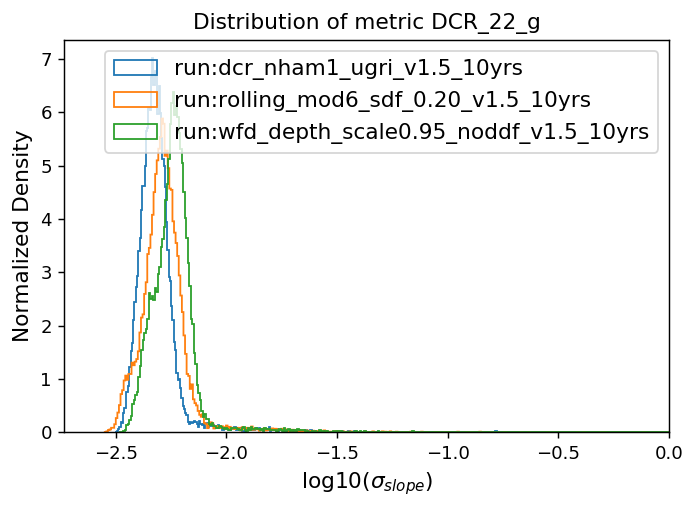

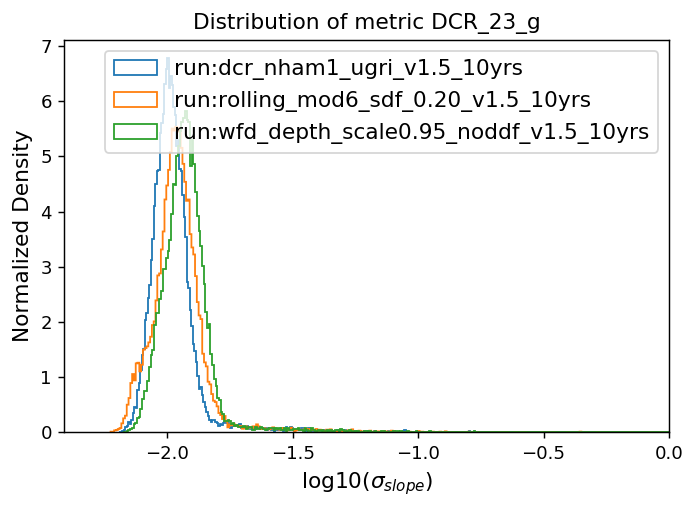

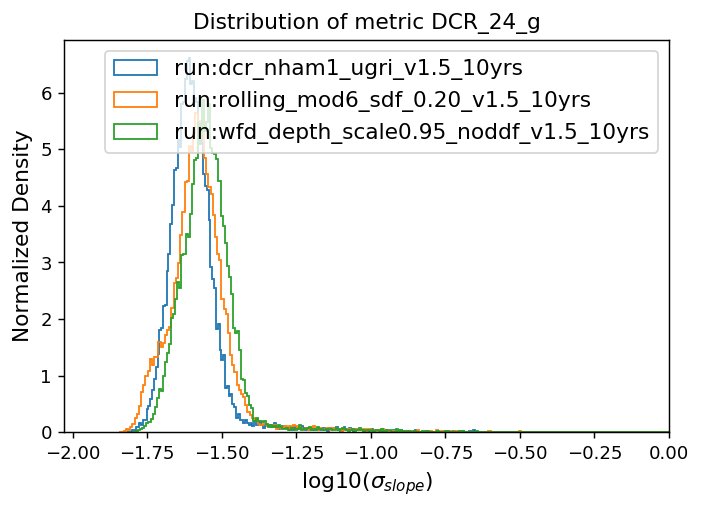

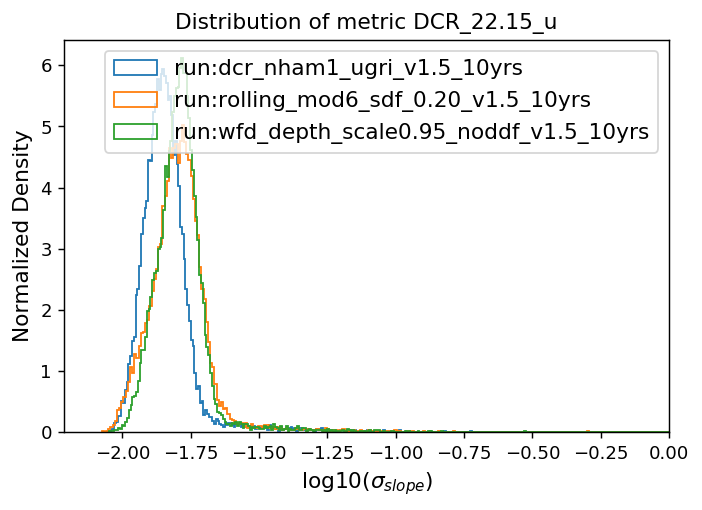

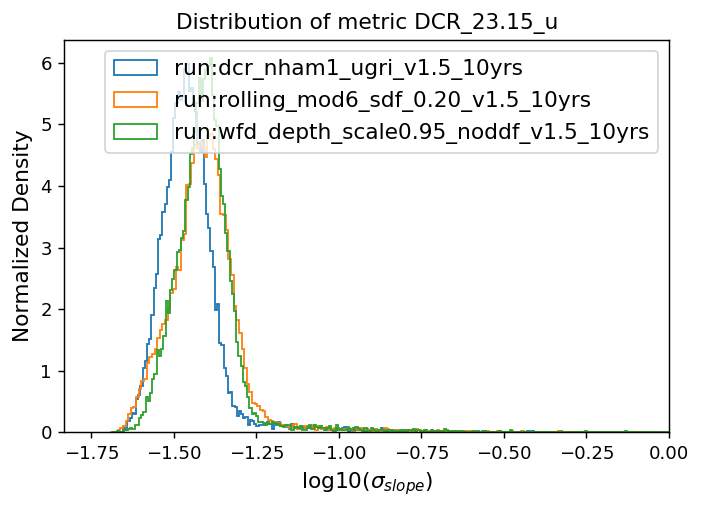

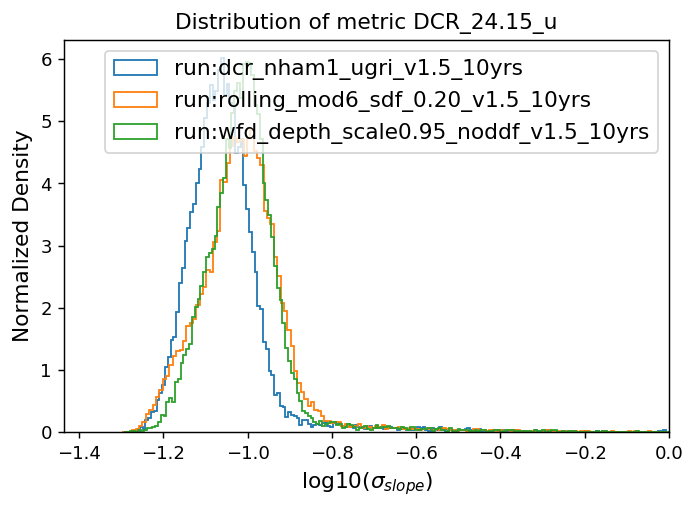

In [19]:
# loop though each metric to make plots, since some values are fairly large 
# and built in functions doesn't allow log scale
for key in bd_keys:
    fig = plt.figure(dpi=130)
    for run in resultDbsView:
        
        # look for the correct combination of metricID and metricName 
        keys = [*bundleDicts[run].keys()]
        metricKey = [elem for elem in keys if elem[1] == key[1]][0]
        
        # need to mask the pixels that have no available data
        mask = bundleDicts[run][metricKey].metricValues.mask
        data = bundleDicts[run][metricKey].metricValues.data[~mask]

        # plot
        _ = plt.hist(np.log10(data), bins='fd', histtype='step', density=True, label=f'run:{run}')
        plt.xlabel('log10($\\sigma_{slope}$)', fontsize=12)
        plt.ylabel('Normalized Density', fontsize=12)
        plt.legend(fontsize=12)
    
    plt.xlim(right=0)
    plt.title(f'Distribution of metric {key[1]}', fontsize=12)

In [65]:
import healpy as hp
def plotSky_Log(mb, scale_func = np.log10, **kwargs):
    '''
    Plot High-Res DDF skymap. 
    Args:
        mb: MetricBundle object.
        ddfName(str): The string name of the DDF field, e.g., COSMOS.
        xsize(int): The dimention of the plot in pixels, default is 250 pixels.
        scale (func): A scaling function for the metric data, e.g., np.log10
    '''

    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        nData = scale_func(data)
    except Exception as e:
        print(e)
        return None
    else:
        mbValues.data[~mask] = nData
        maxVal = np.percentile(nData, 99)

        _ = hp.mollview(mbValues, flip='astro', max=maxVal, **kwargs)

#     _ = hp.graticule()
    plt.title(f'Metric:{mb.metric.name}, RunName:{mb.runName}', fontsize=15)

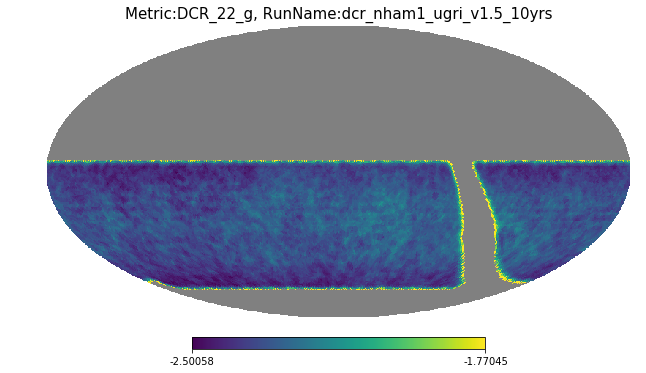

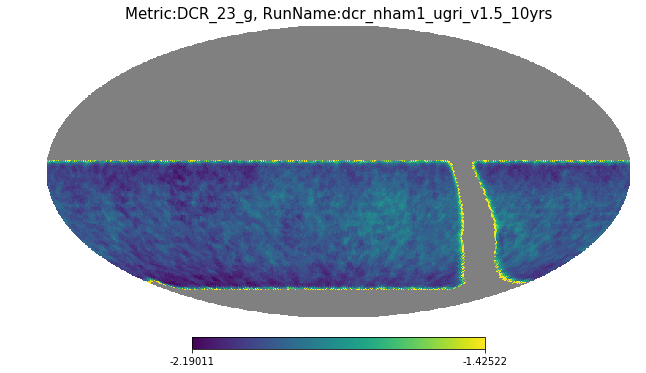

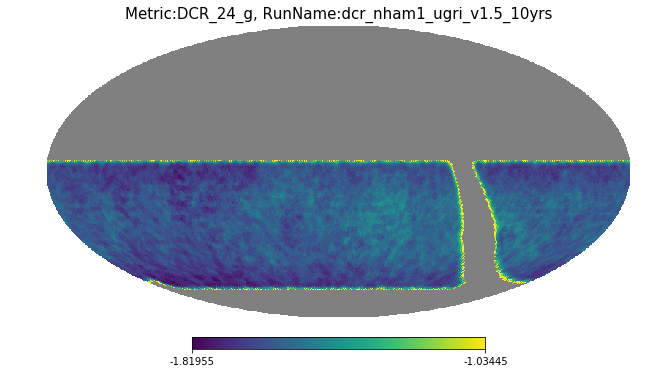

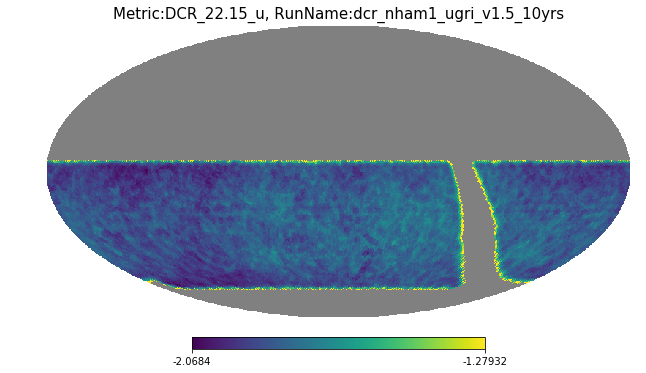

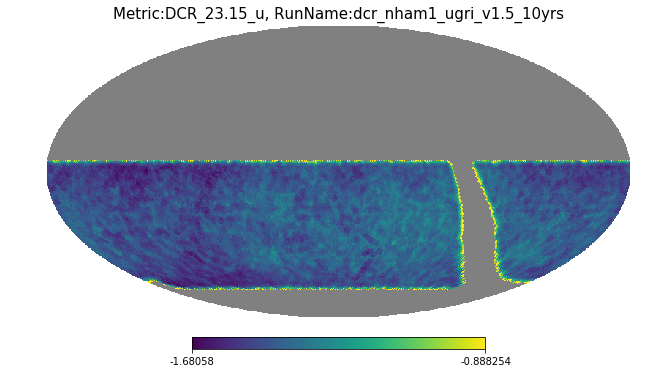

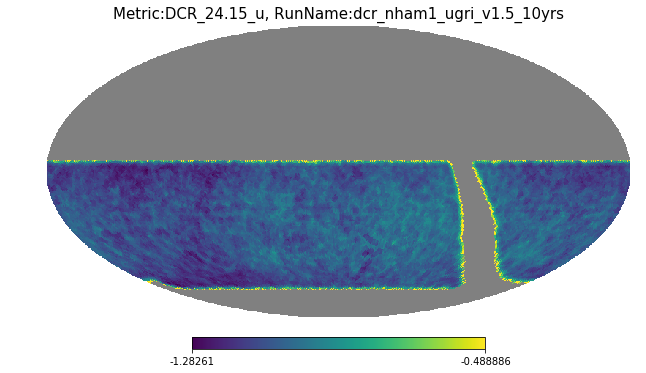

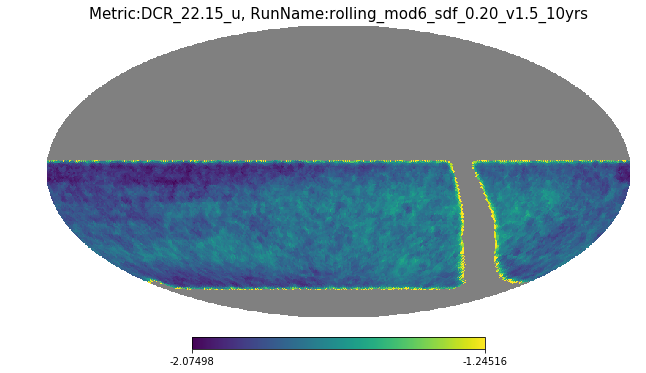

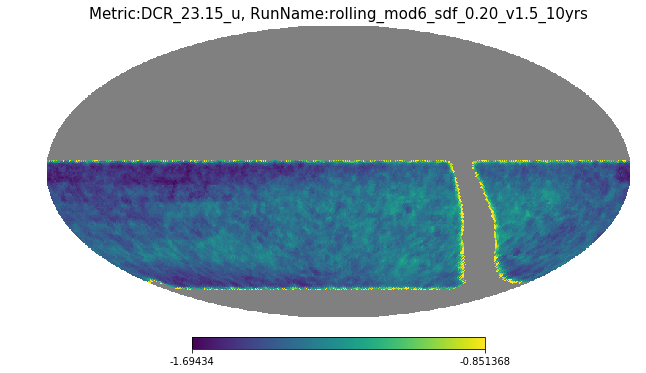

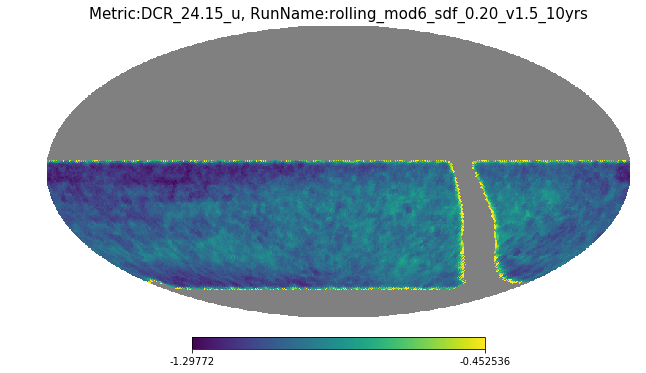

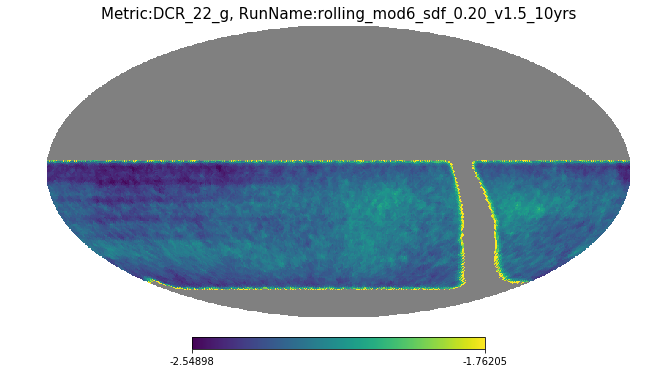

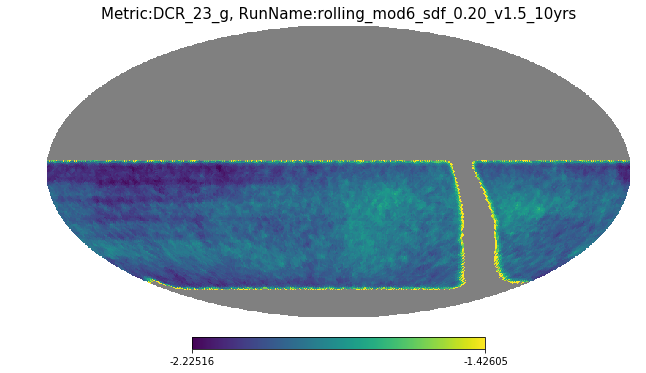

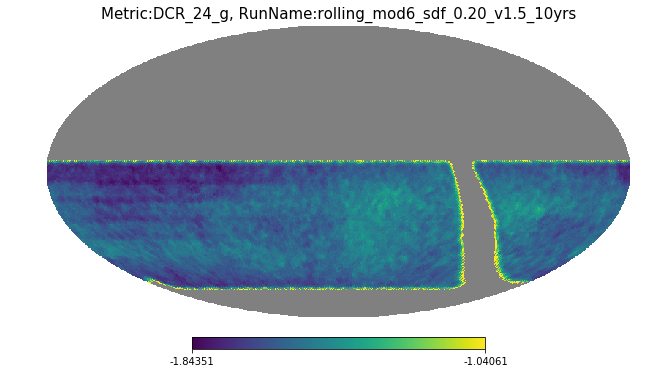

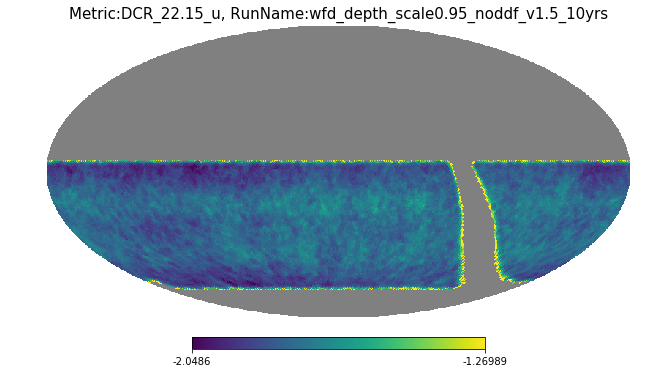

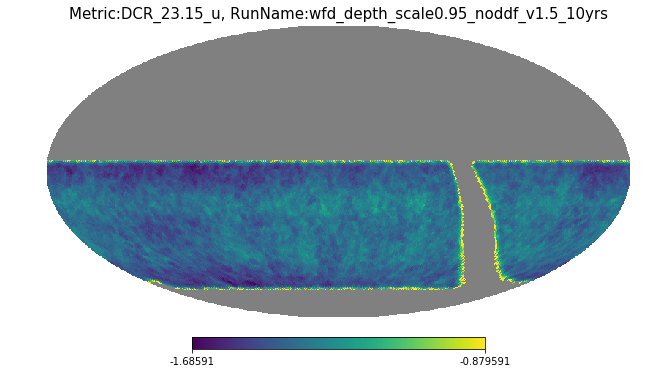

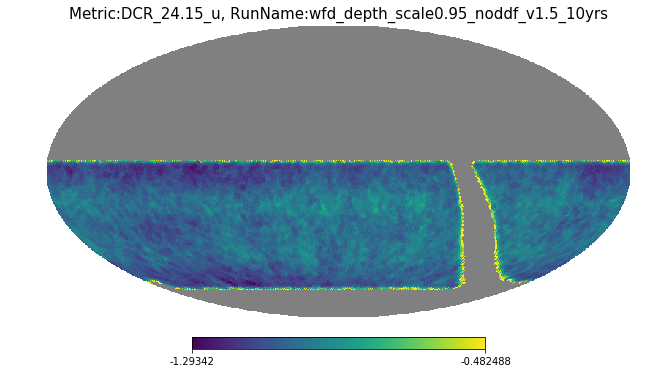

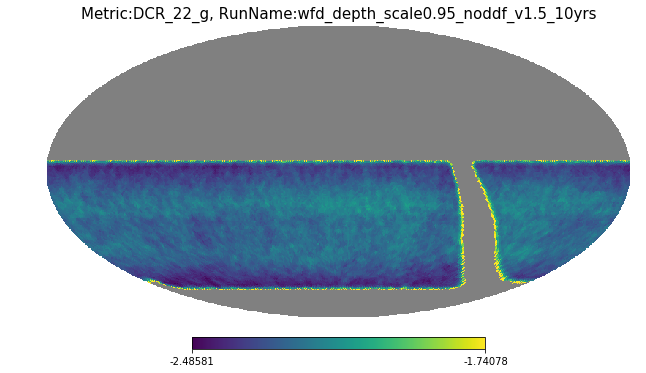

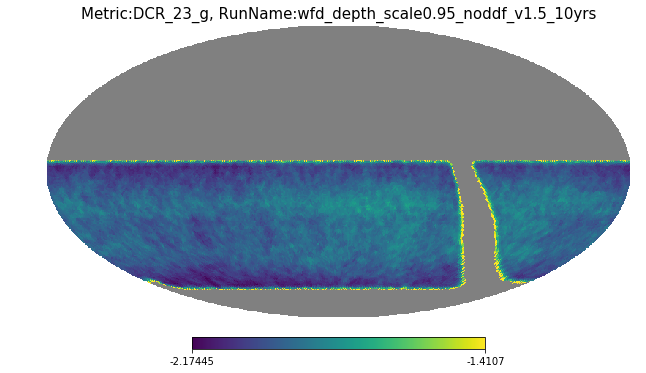

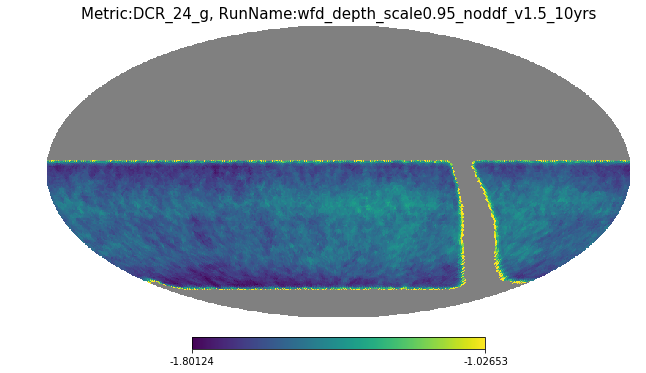

In [66]:
for run in resultDbsView:     
    for key in bundleDicts[run]:
        plotSky_Log(bundleDicts[run][key])

** ---------- Ignore below summary stat ------------------**
---

#### 5.1 Summary statistics for `uMagErrMean_23`

In [17]:
plotHist??

Signature: plotHist(bundleDicts, metricKey, runNames=None, ddf=False, **kwargs)
Source:   
def plotHist(bundleDicts, metricKey, runNames=None, ddf=False, **kwargs):
    '''
    Plot histogram of evaluated metrics for each opsim in the bundleDicts on
    one figure.

    Args:
        bundleDicts(dict): A dictionary of bundleDict, keys are run names.
        metricKey(tuple): A tuple dictionary key for a specific metric, slicer 
            and constraint combination.
        runNames(list): A list of opsim run names from which the metric values use
            to plot histogram are cacluated, default to None, meaning all opsims.
        ddf(bool): True if plotting for DDF, default is False.
    '''
    # init handler
    ph = plots.PlotHandler(savefig=False)

    # init plot
    healpixhist = plots.HealpixHistogram()
    plotDictTemp = {'figsize': (8, 6), 'fontsize': 15, 'labelsize': 13}
    plotDicts = []
    bundleList = []

    # check if bins provided
    bins = kwargs.get('bins')


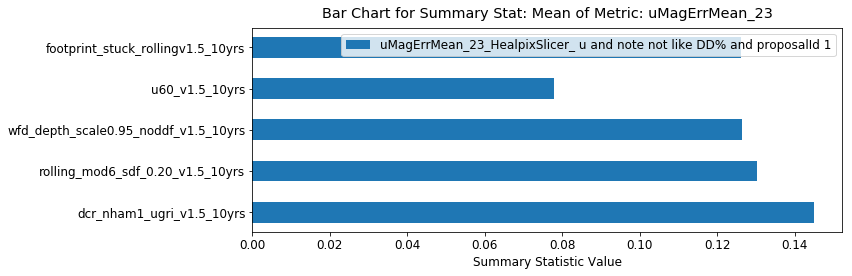

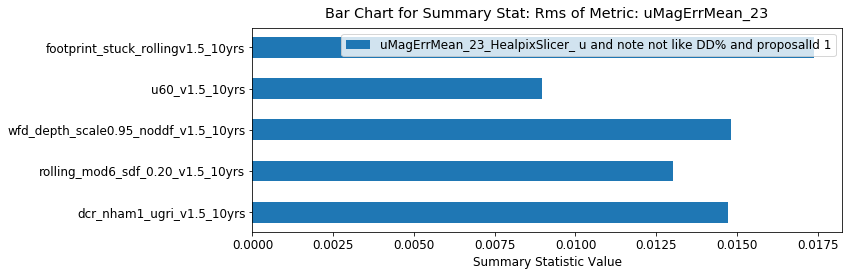

In [28]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'uMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

#### 5.2 Summary statistics for `gMagErrMean_23`

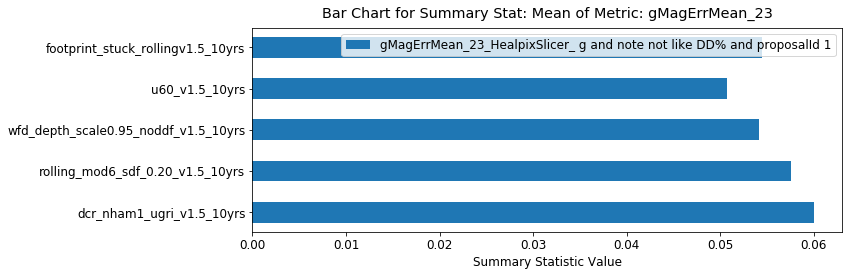

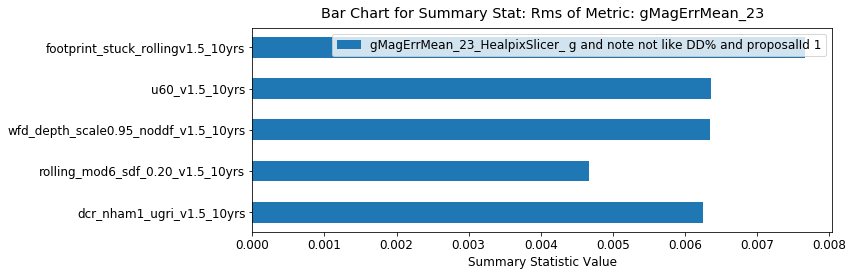

In [29]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Mean', runNames=dbRuns[0:5])

# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'gMagErrMean_23', 'Rms', runNames=dbRuns[0:5])

### 6. Look at the distribution `gMagErrMean_23` over the Sky and a histogram

In [30]:
get_metricMetadata(resultDbs[dbRuns[0]])

,metricId,metricName,slicerName,sqlConstraint,metricMetadata,metricDataFile
0,1,uMagErrMean_23,HealpixSlicer,"filter = ""u"" and note not like ""DD%"" and propo...",u and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_uMagErrMean_23_u_and...
1,2,gMagErrMean_23,HealpixSlicer,"filter = ""g"" and note not like ""DD%"" and propo...",g and note not like DD% and proposalId 1,dcr_nham1_ugri_v1_5_10yrs_gMagErrMean_23_g_and...


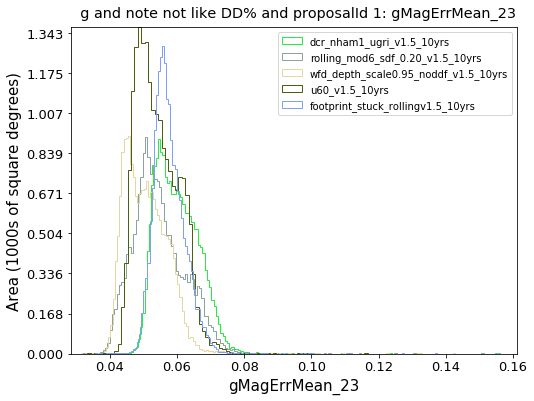

In [34]:
plotHist(bundleDicts, (2, 'gMagErrMean_23'))